In [1]:
import numpy as np
from sksurv.metrics import concordance_index_censored

from api.coxkan import *
from api.auton import datasets, preprocessing

In [2]:
# Load the SUPPORT Dataset
outcomes, features = datasets.load_dataset('SUPPORT')

In [3]:
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 
             'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp', 'adls']

features = preprocessing.Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)
features

,age,num.co,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,...,dzclass_Coma,income_$25-$50k,income_>$50k,income_under $11k,race_black,race_hispanic,race_other,race_white,ca_no,ca_yes
0,0.012772,-1.390013,0.449837,-6.931821e-01,-0.892283,-0.138967,-0.881504,1.569019e+00,-1.655686e+00,-5.238337e-01,...,0,0,0,0,0,0,1,0,0,0
1,-0.148262,0.097711,-1.500702,5.187096e-01,0.470382,1.114591,-2.005013,-1.495658e+00,-6.389701e-16,9.880260e-17,...,0,0,0,0,0,0,0,1,1,0
2,-0.635153,0.097711,-0.525432,-4.201759e-01,-0.290175,0.487812,0.235766,-8.319880e-02,-6.389701e-16,-7.892740e-02,...,0,0,0,1,0,0,0,1,1,0
3,-1.299688,0.097711,-0.344827,-3.546971e-01,-0.290175,0.905665,-1.680444,-3.003564e-16,-6.389701e-16,9.880260e-17,...,0,0,0,1,0,0,0,1,0,0
4,1.105258,-0.646151,-0.922764,1.258366e-01,0.470382,-0.347893,0.635237,-6.997670e-01,-6.389701e-16,9.880260e-17,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,0.219471,-0.646151,0.883291,-5.403626e-01,0.216863,-0.138967,-1.124933,4.276908e-01,1.077955e+00,-4.793410e-01,...,0,0,0,0,0,0,0,1,1,0
9101,-0.480786,-0.646151,-1.500702,1.939826e-16,-3.078884,-1.601451,1.190748,-2.222321e-01,-6.389701e-16,9.880260e-17,...,1,0,0,0,0,0,0,1,1,0
9102,0.495813,-0.646151,0.955533,-4.312668e-01,-0.448624,0.069960,-0.325992,-6.290945e-01,-6.389701e-16,-4.793410e-01,...,0,0,0,0,0,0,0,1,1,0
9103,-1.002436,-0.646151,0.522080,-5.185008e-01,0.407002,0.069960,-0.563174,1.997678e+00,-2.518775e+00,-4.793410e-01,...,0,0,0,0,0,0,0,1,0,1


In [4]:
x, t, e = features.values, outcomes.time.values, outcomes.event.values
# x = x[:,:10]
x

array([[ 0.01277233, -1.39001299,  0.44983742, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14826234,  0.09771103, -1.50070191, ...,  1.        ,
         1.        ,  0.        ],
       [-0.63515269,  0.09771103, -0.52543225, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 0.49581285, -0.64615098,  0.9555328 , ...,  1.        ,
         1.        ,  0.        ],
       [-1.00243569, -0.64615098,  0.52207962, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.21133166, -0.64615098, -0.34482675, ...,  1.        ,
         1.        ,  0.        ]])

In [5]:
# horizons = [0.25, 0.5, 0.75]
# times = np.quantile(outcomes.time[outcomes.event==1], horizons).tolist()
# times

In [6]:
n = len(x)

tr_size = int(n * 0.70)
vl_size = int(n * 0.10)
te_size = int(n * 0.20)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size+vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size+vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size+vl_size]

### Get started with KANs

Initialize KAN

In [7]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = CoxKAN(width=[x_train.shape[1], 1], grid=5, k=3, seed=0)
# model = KAN(width=[2,1,1], grid=5, k=3, seed=0)
optimizer = 'LBFGS'

Create dataset

In [8]:
device='cpu'
dataset = {
    'train_input': torch.from_numpy(x_train).to(device), 
    'val_input': torch.from_numpy(x_val).to(device),
    'test_input': torch.from_numpy(x_test).to(device),
    'train_time': torch.from_numpy(t_train).to(device), 
    'val_time': torch.from_numpy(t_val).to(device),
    'test_time': torch.from_numpy(t_test).to(device),
    'train_event': torch.from_numpy(e_train).to(device),
    'val_event': torch.from_numpy(e_val).to(device),
    'test_event': torch.from_numpy(e_test).to(device)}

Plot KAN at initialization

In [9]:
dataset['train_input'].shape

torch.Size([6373, 38])

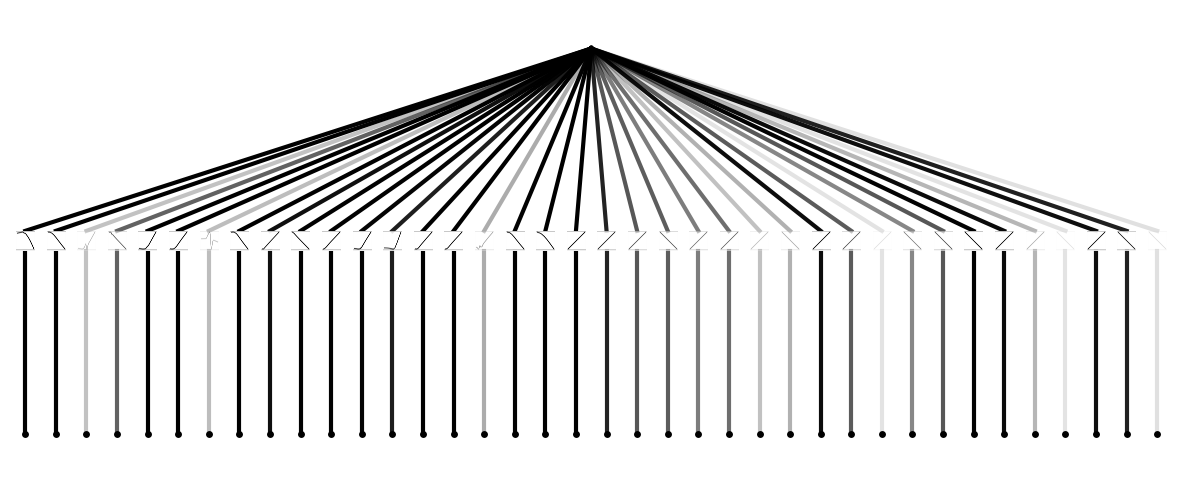

In [10]:
# plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100, scale=1.5)

Train KAN with sparsity regularization

In [11]:
# train the model
model.train()
lr = 0.01
model.fit(dataset, opt=optimizer, steps=20, lr=lr, lamb=0.01, lamb_entropy=10.)

train loss: 2.89e+01 | validation loss: 3.01e+01 | reg: 4.64e+01 : 100%|█| 20/20 [00:08<00:00,  2.31


{'train_loss': [array(30.09128333),
  array(28.50347109),
  array(29.69446928),
  array(30.13605762),
  array(28.39734865),
  array(29.23878879),
  array(28.00052222),
  array(28.26995925),
  array(29.43892672),
  array(29.53959272),
  array(29.25292473),
  array(30.42059058),
  array(29.72041288),
  array(28.67818096),
  array(28.19631347),
  array(28.35236675),
  array(29.69240891),
  array(30.06531015),
  array(29.73302157),
  array(28.8714645)],
 'val_loss': [array(32.84759854),
  array(29.50201624),
  array(29.98274673),
  array(35.74372369),
  array(29.99198367),
  array(29.86635189),
  array(30.12894511),
  array(27.96757778),
  array(28.78625829),
  array(28.53139087),
  array(29.03213433),
  array(29.61142577),
  array(29.100415),
  array(28.70773546),
  array(29.68511478),
  array(29.59876072),
  array(28.65494264),
  array(28.76036509),
  array(28.56105075),
  array(30.06606719)],
 'reg': [array(46.96841169),
  array(47.68377098),
  array(46.36732778),
  array(46.48284936),


Plot trained KAN

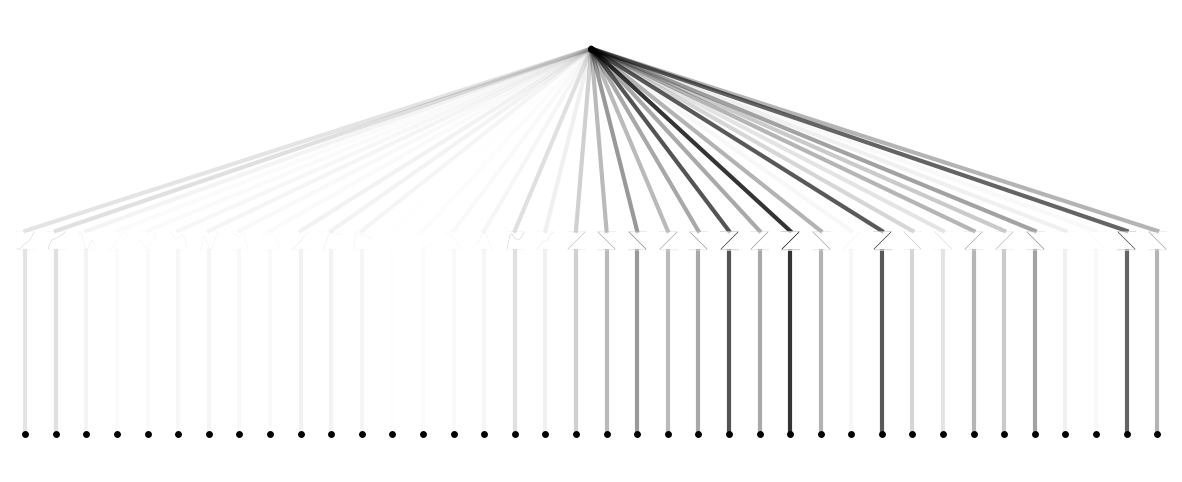

In [12]:
model.plot(scale=1.5)

In [13]:
model(dataset['test_input']).detach().cpu().numpy().flatten()

array([-0.52697171, -0.71168016, -0.70380641, ..., -0.53051835,
        0.00836963, -1.48318095])

In [14]:
concordance_index_censored(
    dataset['test_event'] != 0, 
    dataset['test_time'], 
    model(dataset['test_input']).detach().cpu().numpy().flatten())[0]

0.6576521906799239

Prune KAN and replot (keep the original shape)

In [15]:
# model.prune()
# model.plot(mask=True, scale=1.5)

Prune KAN and replot (get a smaller shape)

In [16]:
# model = model.prune()
# model(dataset['train_input'])
# model.plot(scale=1.5)

Continue training and replot

In [17]:
# model.fit(dataset, opt=optimizer, lr=lr, steps=50)

In [18]:
# model.plot(scale=1.5)

In [19]:
# concordance_index_censored(
#     dataset['test_event'] != 0, 
#     dataset['test_time'], 
#     model(dataset['test_input']).detach().cpu().numpy().flatten())[0]

Automatically or manually set activation functions to be symbolic

In [20]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    # lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with log, r2=0.9848551117048809
fixing (0,1,0) with x^3, r2=0.98055539797047
fixing (0,2,0) with x^2, r2=0.5269802971282741
fixing (0,3,0) with tanh, r2=0.9705409805898998
fixing (0,4,0) with x^2, r2=0.8821105070660916
fixing (0,5,0) with tanh, r2=0.5988099400357483
fixing (0,6,0) with x^2, r2=0.9326547566272209
fixing (0,7,0) with tanh, r2=0.7386345412283268
fixing (0,8,0) with tanh, r2=0.9453010513063513
fixing (0,9,0) with tanh, r2=0.996485451150769
fixing (0,10,0) with log, r2=0.8189986565314211
fixing (0,11,0) with tanh, r2=0.5589491372900751
fixing (0,12,0) with tanh, r2=0.749184448763868
fixing (0,13,0) with tanh, r2=0.746150616189666
fixing (0,14,0) with tanh, r2=0.9980166472337864
fixing (0,15,0) with x^2, r2=0.835195872781558
fixing (0,16,0) with tanh, r2=0.974669687905349
fixing (0,17,0) with sqrt, r2=0.9817399794617717
fixing (0,18,0) with exp, r2=1.0000000000000022
fixing (0,19,0) with exp, r2=1.0000000000000018
fixing (0,20,0) with exp, r2=1.000000000000002

Continue training to almost machine precision

In [35]:
model.fit(dataset, opt=optimizer, lr=lr, steps=20)

train loss: 2.93e+01 | validation loss: 2.93e+01 | reg: 1.15e+01 : 100%|█| 20/20 [00:02<00:00,  6.91


{'train_loss': [array(28.48119243),
  array(29.04118787),
  array(29.43684661),
  array(28.83454657),
  array(28.79428743),
  array(29.1776028),
  array(29.49566715),
  array(29.78028133),
  array(30.60656314),
  array(30.22012777),
  array(29.75123233),
  array(29.22164798),
  array(28.3830867),
  array(29.01830288),
  array(28.50474135),
  array(28.92725796),
  array(29.23589445),
  array(29.83411065),
  array(30.23102238),
  array(29.29501587)],
 'val_loss': [array(nan),
  array(28.88642575),
  array(29.02369636),
  array(nan),
  array(29.32068057),
  array(29.45883049),
  array(29.5815984),
  array(28.82548319),
  array(29.43978857),
  array(nan),
  array(28.0426691),
  array(28.99178153),
  array(30.06050938),
  array(29.07252314),
  array(29.03553215),
  array(29.46066509),
  array(28.2261528),
  array(29.09781891),
  array(29.0646786),
  array(29.27069929)],
 'reg': [array(11.5264342),
  array(11.46089026),
  array(11.45101448),
  array(11.45653401),
  array(11.44846178),
  arra

Obtain the symbolic formula

In [36]:
model.symbolic_formula()[0][0]

0.07*(0.02 - x_7)**2 + 0.04*(0.16 - x_3)**2 - 0.06*(1 - 0.71*x_16)**2 - 0.08*(1 - 0.65*x_2)**3 + 0.43*sqrt(0.4*x_18 + 1) + 0.16*(-x_24 - 0.41)**4 - 0.01*(-x_27 - 0.84)**4 + 0.03*(-x_5 - 0.72)**2 + 0.07*exp(2.17*x_29) + 0.01*exp(2.2*x_33) - 0.01*exp(3.71*x_37) - 0.63*log(1.68 - 0.55*x_1) - 0.71*log(6.1 - 0.79*x_11) + 0.81*tanh(0.38*x_10 - 1.21) + 1.65*tanh(2.43*x_12 + 9.8) + 0.41*tanh(0.41*x_13 - 1.85) - 0.04*tanh(1.34*x_14 + 0.04) - 0.62*tanh(0.26*x_15 - 1.01) + 0.28*tanh(9.6*x_17 + 2.44) + 0.81*tanh(0.11*x_4 - 1.0) - 0.21*tanh(2.23*x_6 - 6.62) - 0.08*tanh(2.23*x_8 - 0.18) - 0.66*tanh(0.55*x_9 - 1.99) - 0.4 - 0.26*exp(-8.0*x_25)

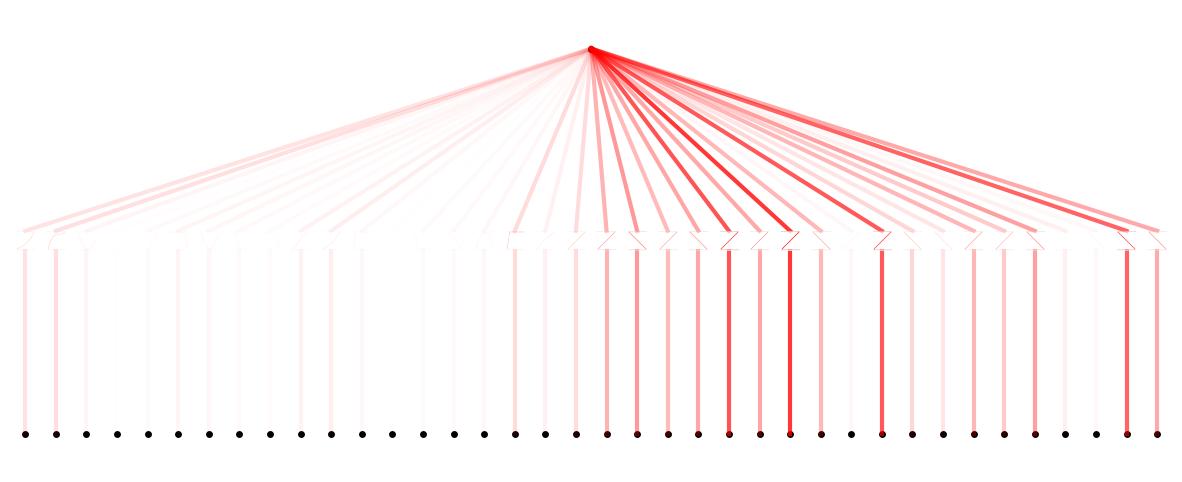

In [37]:
model.plot(scale=1.5)

In [38]:
model(dataset['test_input']).detach().cpu().numpy().flatten()

array([-0.2367604 , -0.77468432, -0.72415152, ..., -0.75109126,
       -0.4670076 , -1.38852857])

In [39]:
concordance_index_censored(
    dataset['test_event'] != 0, 
    dataset['test_time'], 
    model(dataset['test_input']).detach().cpu().numpy().flatten())[0]

0.6592434941735882

In [26]:
# out_risk = model.predict_risk(dataset, times)
# out_survival = model.predict_survival(dataset, times)
# # out_risk = model(dataset['test_input']).detach().cpu().numpy()
# # out_survival = - model(dataset['test_input']).detach().cpu().numpy()

In [27]:
# BreslowEstimator().fit(
#     model(dataset['train_input']).detach().cpu().numpy(), 
#     dataset['train_event'].numpy(), 
#     dataset['train_time'].numpy())

In [28]:
# BreslowEstimator()

In [29]:
# out_survival

In [30]:
# from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
# 
# cis, brs = [], []
# 
# et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))], dtype = [('e', bool), ('t', float)])
# et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))], dtype = [('e', bool), ('t', float)])
# et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))], dtype = [('e', bool), ('t', float)])
# 
# for i, _ in enumerate(times):
#     cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
#     
# brs.append(brier_score(et_train, et_test, out_survival, times)[1])
# 
# roc_auc = []
# for i, _ in enumerate(times):
#     roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
#     
# for horizon in enumerate(horizons):
#     print(f"For {horizon[1]} quantile,")
#     print("TD Concordance Index:", cis[horizon[0]])
#     print("Brier Score:", brs[0][horizon[0]])
#     print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

In [31]:
# from sksurv.linear_model.coxph import BreslowEstimator
# 
# 
# def fit_breslow(model, data):
#     return BreslowEstimator().fit(model(data['train_input']).detach().cpu().numpy(), data['train_event'].numpy(), data['train_time'].numpy())
# 
# breslow_spline = fit_breslow(model, dataset)

In [32]:
# unique_times = breslow_spline.baseline_survival_.x
# unique_times

In [33]:
# breslow_spline.get_survival_function(model(dataset['train_input']).detach().cpu().numpy())

In [34]:
# import pandas as pd
# 
# raw_predictions = breslow_spline.get_survival_function(model(dataset['train_input']).detach().cpu().numpy())
# raw_predictions = np.array([pred.y for pred in raw_predictions])
# 
# predictions = pd.DataFrame(data=raw_predictions, columns=unique_times)